# RAPIDS analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

The dataset we use here comes from [Lareau et al., Nat Biotech 2019](https://www.nature.com/articles/s41587-019-0147-6), one of the highest throughput single-cell ATAC-seq experiments to date. They assay 136K resting and stimulated bone marrow-derived cells and study the different cell types and lineages that emerge. The paper analyzes resting & stimulated cells separately (and we also find that these two populations split into largely distinct clusters), so here we only focus on the 60K resting cells from this experiment.

The cell metadata from this experiment includes annotated putative cell types based on chromVAR, Louvain clustering, and downstream cluster analysis. We compare our de novo identified clusters to these annotated clusters from the paper (and find good agreement).

The peak-cell matrix along with peak and cell metadata files are publicly available on GEO, [GSE123580](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123580).

### Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os, wget

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [2]:
import rmm

rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Set parameters

In [3]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [4]:
start_time = time.time()

## Input data

In the cell below, we provide the path to the sparse .h5ad file containing the peak x cell count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

In [5]:
%%time
input_file = "../data/dsci_resting_nonzeropeaks.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/dsci_resting_nonzeropeaks.h5ad',
                  input_file)

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()
print(adata.X.shape)

(60495, 143691)
CPU times: user 281 ms, sys: 344 ms, total: 625 ms
Wall time: 723 ms


## Preprocessing

In [6]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [7]:
%%time

lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.01 s, sys: 895 ms, total: 2.91 s
Wall time: 2.91 s


### Frequency-based peak selection
We want to choose peaks that have highest discriminative power between cells. A good proxy for discriminative power is variance; since peak data (especially on a sparse dataset like this) is essentially binary, the highest variance peaks are the ones with closest to 50\% representation across cells (p=1/2 maximizes Bernoulli variance). The most frequent peak in this dataset only has 33\% representation, so in practice we just end up taking the top N most frequent peaks, where N is a parameter we set above (default 25000).

In [8]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(60495, 25000)
CPU times: user 931 ms, sys: 245 ms, total: 1.18 s
Wall time: 1.17 s


In [9]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 4.10sec


## Cluster & Visualize

### PCA

In [10]:
%%time
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 35.4 s, sys: 25.5 s, total: 1min
Wall time: 1min


(60495, 50)

### UMAP visualization

In [11]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 3.72 s, sys: 355 ms, total: 4.08 s
Wall time: 4.3 s


In [12]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 361 ms, sys: 289 ms, total: 649 ms
Wall time: 652 ms


### Graph clustering

Below, we show how to use the RAPIDS Louvain clustering or Leiden clustering functions to cluster the data.

In [13]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 78.1 ms, sys: 15.8 ms, total: 93.9 ms
Wall time: 92.4 ms


In [14]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 45 ms, sys: 12.7 ms, total: 57.7 ms
Wall time: 56.5 ms


Below, we plot the UMAP visualization of the cells colored by the Louvain clusters. Next, we color the cells using the cell type annotations reported in the source paper. We see that the clusters we discovered match closely with the reported cell types.

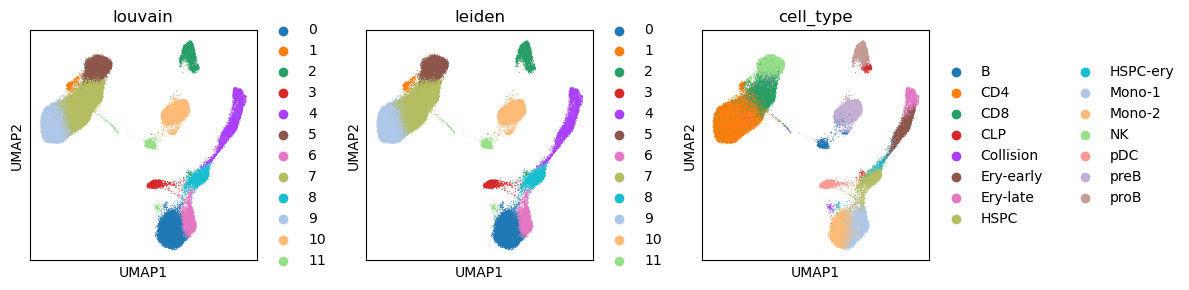

CPU times: user 5.82 s, sys: 3.71 s, total: 9.53 s
Wall time: 1.82 s


In [15]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### tSNE visualization

In [16]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:, :tsne_n_pcs])

[W] [19:53:51.493511] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 875 ms, sys: 603 ms, total: 1.48 s
Wall time: 1.48 s


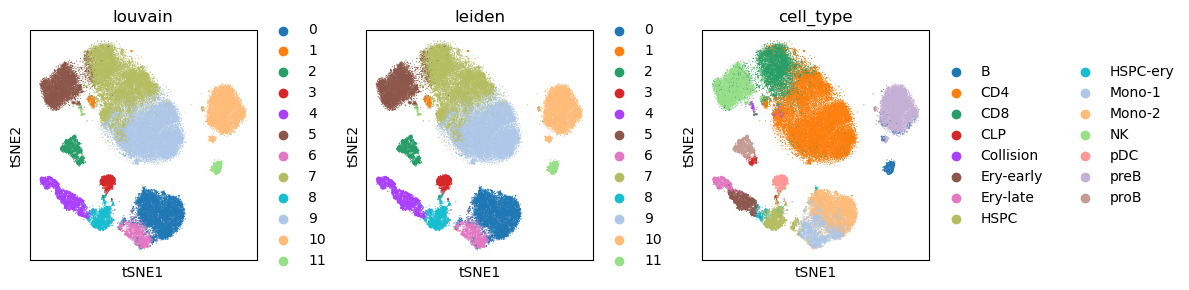

CPU times: user 1.8 s, sys: 108 ms, total: 1.91 s
Wall time: 1.66 s


In [17]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### Marker genes

We now compute a gene activity score representing the activity of each marker gene in each cell. We use the `adata_raw` object to compute this score. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [18]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 434 ms, sys: 3.3 ms, total: 438 ms
Wall time: 436 ms


In [19]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 2.18 s, sys: 9.89 ms, total: 2.19 s
Wall time: 2.19 s


We now visualize the UMAP plot colored by activity of marker genes. We observe that the activation of cell-type specific marker genes correlates well with the cell types identified by Louvain clustering.

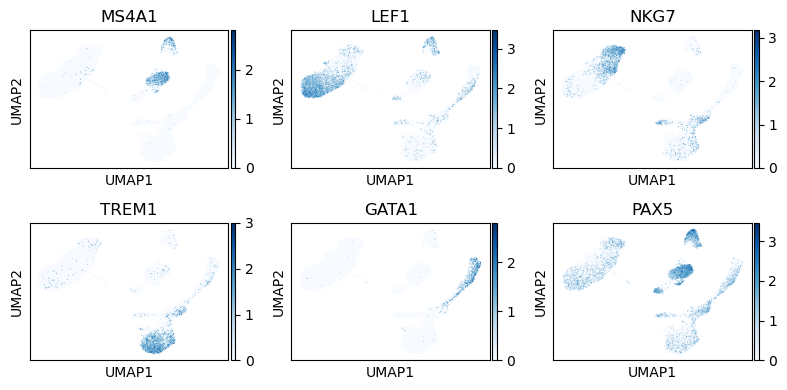

CPU times: user 1.59 s, sys: 158 ms, total: 1.75 s
Wall time: 1.49 s


In [20]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find Differential peaks

We perform an accelerated logistic regression-based differential peak computation using RAPIDS. This function may not give the exact same results as the equivalent Scanpy CPU function.

In [21]:
%%time
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(adata.var_names)
dense_gpu_array = cp.sparse.csr_matrix(cp.array(adata.X))

scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    dense_gpu_array,
    cluster_labels, 
    var_names, 
    penalty='none',
    n_genes=n_diff_peaks, groups='all', reference='rest')

[W] [19:54:05.630913] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
CPU times: user 5.02 s, sys: 1.93 s, total: 6.95 s
Wall time: 6.99 s


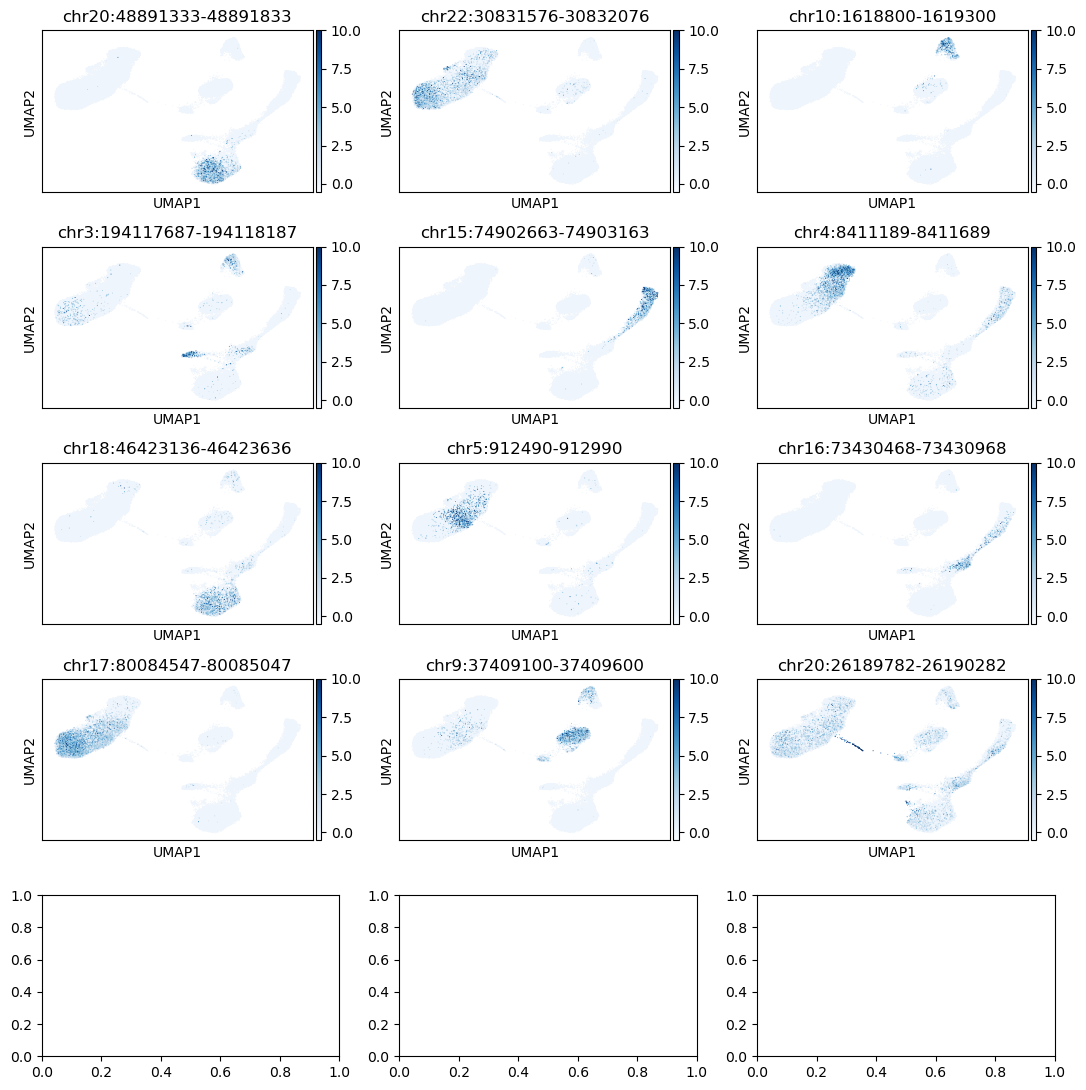

CPU times: user 3.52 s, sys: 116 ms, total: 3.64 s
Wall time: 3.37 s


In [22]:
%%time
fig, axs = plt.subplots(len(names[0])//3 + 1, 3, figsize=(11,11), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(names[0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=10, vmin=-0.5,
           cmap='Blues'
          )
plt.tight_layout()
plt.show()

In [23]:
print("Full time: %.2fsec" % (time.time() - start_time))

Full time: 90.28sec
